<a href="https://colab.research.google.com/github/Faizan-er/ResearchWork03/blob/main/M1A_fy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Ultrasound Image-Based Diagnosis Thyroid Nodule Using Deep Learning**

In [ ]:
#Importing Libraries

import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import cv2


import math
import random


import xml.etree.ElementTree as ET
from natsort import natsorted
import requests
from zipfile import ZipFile
from io import BytesIO
from six.moves import xrange
import collections
import string

## **Functions for Loading and preparing the data.**

In [ ]:
#F1: Creating Df(structured) from XML and Jpeg 

def Create_dataframe(path):
    dirs=natsorted(os.listdir(path))
    xml_list=[]
    img_list=[]
    for i in range(len(dirs)):
        if '.xml' in dirs[i]:
            xml_list.append(dirs[i])
        if not '.xml'  in dirs[i]:
            img_list.append(dirs[i])
    xml_list=natsorted(xml_list)
    img_list=natsorted(img_list)
    tirads=[]
    for j in range(len(xml_list)):
        tree = ET.parse(path+'/'+xml_list[j])
        a=tree.findall("./tirads")
        if a[-1].text!=None:
            case=[xml_list[j],a[-1].text]
            tirads.append(case)
    data=[]
    for k in range(len(tirads)):
        xml=tirads[k][0][:-4]
        for z in range(len(img_list)):
            if xml+'_1.jpg'==img_list[z] or xml+'_2.jpg'==img_list[z] or xml+'_3.jpg'==img_list[z]:
                m=[img_list[z],tirads[k][1]]
                data.append(m)

    df = pd.DataFrame(data,columns =['Jpeg_Name', 'Tirads'])
    return df

In [ ]:
#F2: Cropp Function

def croping(img,x, y, w, h):
    if abs(w)<abs(h):
        img2=np.zeros([h,h])
        img2[:,h-w:h]=img[y:y+h, x:x+w]
    if abs(h)<abs(w):  
        img2=np.zeros([w,w])
        img2[w-h:w,:]=img[y:y+h, x:x+w]
    else:
        return img
    return img2


In [ ]:
#F3:  Convert RGB to grayscale, If some Images are colour 

def convert_one_channel(img):
    #if some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

In [ ]:
#F4:Remove Fill area from Image and Resizeing
#Calling F3 and F2
#used CV2 

def crop_resize(path,resize_shape):
    img=plt.imread(path)
    img=convert_one_channel(np.asarray(img))        
    kernel =( np.ones((5,5), dtype=np.float32))
    ret,thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    a1,b1=thresh.shape
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel,iterations=3 )
    thresh=cv2.erode(thresh,kernel,iterations =5)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c_area=np.zeros([len(contours)])
    for i in range(len(contours)):
        c_area[i]= cv2.contourArea(contours[i]) 
    cnts=contours[np.argmax(c_area)]    
    x, y, w, h = cv2.boundingRect(cnts)
    roi = croping(img, x, y, w, h)                 #F2
    roi=cv2.resize(roi,(resize_shape),interpolation=cv2.INTER_LANCZOS4)
    return roi

In [ ]:
#F5: TO Data Matrix
#Calling F4

def to_imgmatrix(resize_shape,path,df):
    path=path+'/'  
    images=crop_resize(path+df["Jpeg_Name"][0],resize_shape)
    for i in range (1,len(df["Jpeg_Name"])):
        img=crop_resize(path+df["Jpeg_Name"][i],resize_shape)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(df["Jpeg_Name"]),resize_shape[0],resize_shape[1],1))
    return images

In [ ]:
#F5: Prepare_date for train (final Touch)
#Calling F1 and F5

def prepare_data(path,resize_shape):
    df=Create_dataframe(path)
    data=to_imgmatrix(resize_shape,path,df) 
    return df, data

***Checking Functions syntax error and working***

In [ ]:
df1= Create_dataframe('/content/drive/MyDrive/Final Year Project/TDID_DATASET_FYPROJECT')
df1[0:5]

,Jpeg_Name,Tirads
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a
3,5_1.jpg,5
4,6_1.jpg,4b


### Loading and preparing Data for Training using above defined function

In [ ]:
df,data = prepare_data('/content/drive/MyDrive/Final Year Project/TDID_DATASET_FYPROJECT', (256,256))

In [ ]:
df[:3]

,Jpeg_Name,Tirads
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a


In [ ]:
data[0]

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[49.54744944],
        [37.15056468],
        [36.99647253],
        ...,
        [18.40408377],
        [21.62313155],
        [23.75513912]],

       [[58.29387081],
        [49.24672126],
        [43.34024133],
        ...,
        [21.97024531],
        [24.18674312],
        [22.4355235 ]],

       [[37.26666894],
        [38.14333271],
        [37.79830443],
        ...,
        [27.56584911],
        [26.44941745],
        [24.1395009 ]]])

### Creating y as categorical data to give as an input to model:

In [ ]:
len(df["Tirads"])

347

In [ ]:
# We need numeric category
#There are little categories, so i handled manually
#only 6 categories(0 to 5):  1 (Benign) | 2 (Benign) | 4a (Malign) | 4b (Malign) | 4c (Malign) | 5 (Malign)

def to_categoricalmatrix(df):
    Y=np.zeros([len(df["Tirads"])])
    for i in range(len(df["Tirads"])):
        if df["Tirads"][i]=="2":
          Y[i]=0
        if df["Tirads"][i]=="3":
          Y[i]=1
        if df["Tirads"][i]=="4a":
          Y[i]=2
        if df["Tirads"][i]=="4b":
          Y[i]=3
        if df["Tirads"][i]=="4c":
          Y[i]=4
        if df["Tirads"][i]=="5":
          Y[i]=5
    return Y

In [ ]:
# 1,2,4a,4b,4c,5 to integer 

y=to_categoricalmatrix(df) # df causing error so providing  df[0] | we can also use df1
y[:8] 

array([0., 2., 2., 5., 3., 2., 4., 3.])

In [ ]:
#  tf.keras.utils.to_categorical  : Converts a class vector (integers) to binary class matrix.
# Each image corrosponds to vector of size 6

y=tf.keras.utils.to_categorical(y, dtype='float32')
y[:8] 

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

Read Documnetation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

## Before Training Our Model we also need to normalize to the images :

In [ ]:
def normalize(data):
  for i in range(len(data)):
    data[i,:,:,:]=data[i,:,:,:]*(1/np.max(data[i,:,:,:]))
  return np.float32(data)
  
# we need noormalize to images
X=normalize(data)
X[300:303]

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.08669087],
         [0.08138052],
         [0.09143508],
         ...,
         [0.07528018],
         [0.10580184],
         [0.10338718]],

        [[0.09409396],
         [0.11260125],
         [0.1153701 ],
         ...,
         [0.09481132],
         [0.07504234],
         [0.07055338]],

        [[0.09266245],
         [0.09153491],
         [0.10222842],
         ...,
         [0.07456926],
         [0.08135484],
         [0.09945331]]],


       [[[0.        ],
         [0.        ],
         [0.  

### Let’s see , random examples from X :

(-0.5, 255.5, 255.5, -0.5)

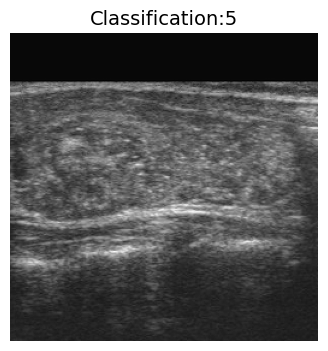

In [ ]:
import random
random_number= random.randint(0,len(df["Tirads"]))    #to seek random value from trids category

plt.figure(figsize= (6,4))

Im_title = "Classification:"+str(df["Tirads"][random_number])
plt.title(Im_title, fontsize=14)
plt.imshow(X[random_number,:,:,0], cmap="gray")

plt.axis("off")

#  Train Test and Validation split

In [ ]:
print(y.shape)
data.shape

(347, 6)


(347, 256, 256, 1)

In [ ]:
X_train = np.copy(X[:300,:,:,:])
X_test = np.copy(X[313:,:,:,:])
X_val = np.copy(X[300:313,:,:,:])


y_train = np.copy(y[:300,:])
y_test = np.copy(y[313:,:])
y_val = np.copy(y[300:313,:])

#  Pre-processing: Data Augmentation:
- Pre-processing is the initial stage in refining image data, such as removing distortion, so that it may be utilized to process data more effectively. We apply many methods of pre-processing in this study, including augmentation, which tries to avoid overfitting so that even if the device encounters a difficulty with micro variations, the software can still make accurate predictions.

- So ,The augmentation used is a random rotation distance of 20, random zooming area in the range of 0.2, a random contrast in the range of 0.1, and, a random horizontal flip.

In [ ]:
#Data Augmention for to prevent Overfitting and to improve accuracy

from tensorflow.keras import layers

data_augmentation1 = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal"),
 layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2),fill_mode="constant"),
 layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.2),fill_mode="constant"),
 tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)])

X_train1=data_augmentation1(X_train)
y_train1=np.copy(y_train)


i=1

#22
while(i<22):
  X_aug=data_augmentation1(X)
  X_train1=np.concatenate((X_train1,X_aug),axis=0)
  y_aug=np.copy(y)
  y_train1=np.concatenate((y_train1,y_aug))

  #20
  if i == 20:
    break
  i += 1

In [ ]:
X_train.shape

(300, 256, 256, 1)

In [ ]:
X_train1.shape

(7240, 256, 256, 1)

# Model Creating

- During training, the input to our VGG-19 is a fixed-size 256 × 256 gray scale image. The image is passed through a stack of convolutional (conv.) layers, where we use filters with a very small receptive field: 3 × 3 .The padding is same for 3 × 3 convolution layers.Max-pooling is performed over a 2 × 2 pixel window, with stride 2. A stack of convolutional layers is followed by three Fully-Connected (FC) layers: the first two have 1024 channels each.The final layer is the soft-max layer.. All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity.

In [ ]:
def VGG19(input_shape,filters):
    inputs=tf.keras.layers.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    x= tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    last = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='top_conv')(x)
    
    model=tf.keras.Model(inputs,last,name="VGG19")
    return model

In [ ]:
base_model=VGG19(input_shape=(256,256,1),filters=512)
x = base_model.output
f=tf.keras.layers.Flatten(name="flatten")(x)

#To prevent overfitting and unbalancing , used regularizer

d2=tf.keras.layers.Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(0.00001))(f)
dp9=tf.keras.layers.Dropout(0.5)(d2)
d3=tf.keras.layers.Dense(1024,activation="relu")(f)
dp10=tf.keras.layers.Dropout(0.5)(d2)

final=tf.keras.layers.Dense(6,activation="softmax")(dp10)
model = tf.keras.Model( inputs =[ base_model.input], outputs = final)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                           

In [ ]:
base_model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                           

In [ ]:
#Metrics | loss  | model.fit()
metrics = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation'
)


#categorical_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=metrics)


def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 15
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

#after each 15 epochs , we want to decrease learning rate for converge to model
lr_call = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
epochs=35


history=model.fit(x=[X_train1],y=[y_train1],batch_size=4,epochs=epochs,callbacks=[lr_call],validation_data=(X_val,y_val))

Epoch 1/35
1810/1810 [==============================] - 235s 120ms/step - loss: 10.3177 - auc: 0.5995 - val_loss: 4.7546 - val_auc: 0.3669 - lr: 1.0000e-04
Epoch 2/35
1810/1810 [==============================] - 216s 119ms/step - loss: 3.3256 - auc: 0.6122 - val_loss: 2.6181 - val_auc: 0.3864 - lr: 1.0000e-04
Epoch 3/35
1810/1810 [==============================] - 216s 119ms/step - loss: 2.2719 - auc: 0.6551 - val_loss: 6.7216 - val_auc: 0.4337 - lr: 1.0000e-04
Epoch 4/35
1810/1810 [==============================] - 216s 119ms/step - loss: 2.1626 - auc: 0.6788 - val_loss: 3.1076 - val_auc: 0.3213 - lr: 1.0000e-04
Epoch 5/35
1810/1810 [==============================] - 216s 119ms/step - loss: 2.0183 - auc: 0.7108 - val_loss: 3.2004 - val_auc: 0.3911 - lr: 1.0000e-04
Epoch 6/35
1810/1810 [==============================] - 215s 119ms/step - loss: 1.8575 - auc: 0.7518 - val_loss: 2.6065 - val_auc: 0.5249 - lr: 1.0000e-04
Epoch 7/35
1810/1810 [==============================] - 215s 119ms/st

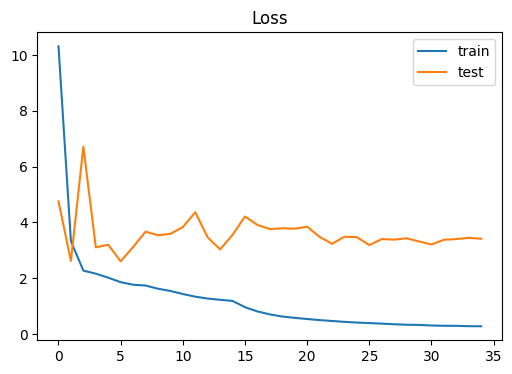

In [ ]:
# Lets see our validation and training loss .

plt.figure(figsize = (6,4))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
model.save('model_vgg19.h5')

In [ ]:
# load the saved model
loaded_model = tf.keras.models.load_model('./saved_model')

# use the loaded model to make predictions
predictions = loaded_model.predict(X_test)
predictions

2/2 [==============================] - 0s 47ms/step


array([[1.50670030e-05, 1.16788869e-05, 5.99030077e-01, 2.58493155e-01,
        1.36870936e-01, 5.57904970e-03],
       [9.98051167e-01, 4.39478055e-04, 5.50591976e-05, 1.15200912e-03,
        2.74137972e-04, 2.82396813e-05],
       [1.91934378e-05, 7.81696737e-02, 1.94994005e-04, 1.42348837e-03,
        9.19942737e-01, 2.49924225e-04],
       [1.15464311e-04, 3.56631754e-05, 5.49751706e-02, 6.83559597e-01,
        2.43532792e-01, 1.77812874e-02],
       [2.31338758e-03, 8.58097774e-05, 8.60151112e-01, 1.09719381e-01,
        2.30482835e-02, 4.68206685e-03],
       [8.22769721e-07, 1.33749074e-06, 9.59594607e-01, 3.88756692e-02,
        4.03188373e-04, 1.12441601e-03],
       [1.14488666e-05, 1.91838225e-08, 9.98960018e-01, 5.45184244e-04,
        4.82354226e-04, 9.75827334e-07],
       [1.83708209e-03, 4.95385565e-03, 3.15996468e-01, 4.24830794e-01,
        1.50461167e-01, 1.01920649e-01],
       [1.15802095e-06, 7.67123197e-07, 1.31293709e-04, 1.52581278e-02,
        1.07640820e-03, 

In [ ]:
import numpy as np
y_pred = np.argmax(predictions, axis=1)
y_pred

array([2, 0, 4, 3, 2, 2, 2, 3, 5, 1, 0, 0, 4, 2, 2, 4, 4, 4, 4, 2, 4, 4,
       4, 4, 5, 3, 4, 4, 2, 2, 0, 4, 4, 5])

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 38ms/step - loss: 2.8466 - auc: 0.7537


[2.846595287322998, 0.7537197470664978]

In [ ]:
from tensorflow import keras
img_array=X_test[0,:,:,:]

img_array=np.reshape(img_array,(1,256,256,1))
preds = model.predict(img_array)
last_conv_layer_name = "top_conv"
classifier_layer_names = ["flatten"]   

              
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
img = keras.preprocessing.image.img_to_array(X_test[0,:,:,:])
img

1/1 [==============================] - 0s 48ms/step


array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.17893486],
        [0.1730036 ],
        [0.18282211],
        ...,
        [0.11155553],
        [0.103765  ],
        [0.09185795]],

       [[0.16936955],
        [0.19652928],
        [0.21530469],
        ...,
        [0.06439782],
        [0.07955465],
        [0.07257421]],

       [[0.12346689],
        [0.15149866],
        [0.20617886],
        ...,
        [0.07321745],
        [0.07082736],
        [0.06255702]]], dtype=float32)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.765


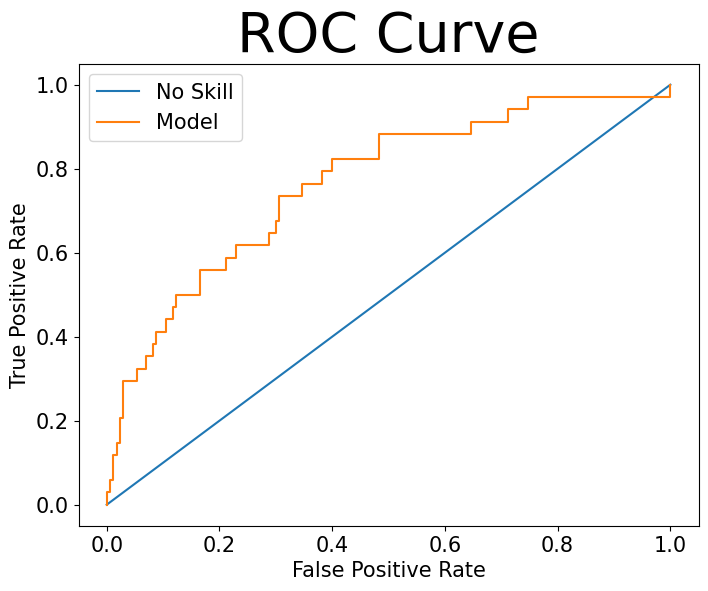

In [ ]:
#Next ROC Curve :

y_test=np.reshape(y_test,(34*6))
predict=np.reshape(predict,(34*6))
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, predict)


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)


# plot the roc curve for the model
plt.figure(figsize = (8,6))
plt.title("ROC Curve",fontsize = 40)
plt.plot(ns_fpr, ns_tpr,label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Model')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["font.size"] = "15"

# show the legend
plt.legend()

# show the plot
plt.show()